# Development Tools
基本就是老生常谈的**Debugging， Testing, Mocking, logging, benchmarking, Inspection, code evaluation, tracing, profiling**这几个部分。

## Debugging
简单来说就是进入到错误的状态，可以查看相应的变量。关于这一块我使用的是Spyder IDE，配合工具自带的variable explorer以及debugger，感觉挺好用的。
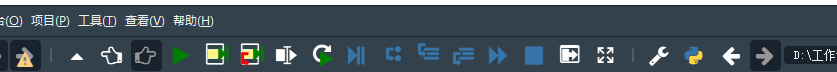

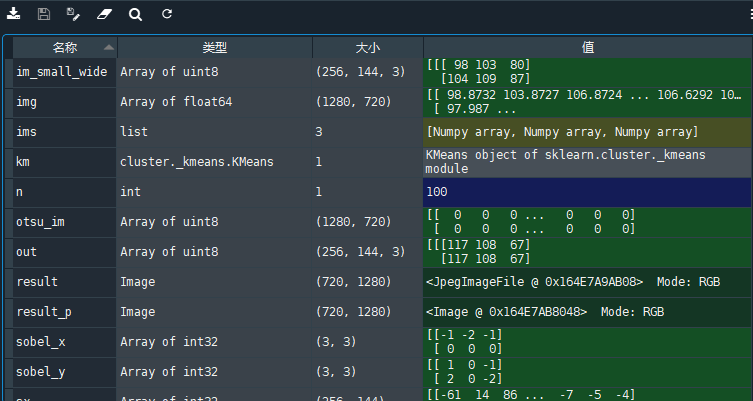

一个debugger（如py的pdb）的实现逻辑大致是，在断点前加入一个特殊的函数调用，每当解释器执行当前栈时，该调用会复制一个一样的runtime environment，并起一个repl，开发者便能在该repl下查看进程的当前状态。

其中debugger几个比较重要的方法，包括"next, continue, list"。

## Inspection
PY作为一个动态语言，允许用户修改他的进行时对象的状态，实时检查对象的状态是每个动态语言的基础，Python的标准库inspect有这样的能力。

In [3]:
import inspect

def inspect_object(o):
    if inspect.isfunction(o) or inspect.ismethod(o):
        print('FUNCTION, arguments:', inspect.signature(o))
    elif inspect.isclass(o):
        print('CLASS, methods:',
             inspect.getmembers(o, inspect.isfunction))
    else:
        print('OBJECT ({}): {}'.format(
            o.__class__,
            [(n, v) for n, v in inspect.getmembers(o)
                if not n.startswith('__')]
        ))
        
class Myclass:
    def __init__(self):
        self.value = 5
        
    def sum_to_value(self, other):
        return self.value + other
    


In [4]:
inspect_object(Myclass.sum_to_value)

FUNCTION, arguments: (self, other)


In [5]:
o = Myclass()
inspect_object(o)

OBJECT (<class '__main__.Myclass'>): [('sum_to_value', <bound method Myclass.sum_to_value of <__main__.Myclass object at 0x000001F605F8B948>>), ('value', 5)]


In [6]:
inspect_object(Myclass)

CLASS, methods: [('__init__', <function Myclass.__init__ at 0x000001F605632948>), ('sum_to_value', <function Myclass.sum_to_value at 0x000001F605632798>)]


## Tracing code

我要讲解的重头戏内容。
为什么要tracing code呢，因为想要traces the execution of a provided function and see the behavior of our software or third-party function。

In [11]:
import trace
import collections


def report_tracing(func, *args, **kwargs):
    outputs = collections.defaultdict(list)
    
    tracing = trace.Trace(trace=False)
    tracing.runfunc(func, *args, **kwargs)
    
    traced = collections.defaultdict(set)
    for filename, line in tracing.results().counts:
        traced[filename].add(line)
    
    for filename, tracedlines in traced.items():
        with open(filename) as f:
            for idx, fileline in enumerate(f, start=1):
                outputs[filename].append((idx, idx in tracedlines, fileline))

    return outputs

In [12]:
def print_traced_execution(tracings):
    for filename, tracing in tracings.items():
        print(filename)
        for idx, executed, content in tracing:
            print('{:04d}{} {}'.format(idx, '+' if executed else ' ', content),
                 end='')
        print()

In [5]:
from tinydb import TinyDB, Query

In [13]:
print_traced_execution(report_tracing(TinyDB, 'db.json'))

D:\anaconda3\lib\site-packages\tinydb\database.py
0001  """
0002  This module contains the main component of TinyDB: the database.
0003  """
0004  from typing import Dict, Iterator, Set
0005  
0006  from . import JSONStorage
0007  from .storages import Storage
0008  from .table import Table, Document
0009  
0010  
0011  class TinyDB:
0012      """
0013      The main class of TinyDB.
0014  
0015      The ``TinyDB`` class is responsible for creating the storage class instance
0016      that will store this database's documents, managing the database
0017      tables as well as providing access to the default table.
0018  
0019      For table management, a simple ``dict`` is used that stores the table class
0020      instances accessible using their table name.
0021  
0022      Default table access is provided by forwarding all unknown method calls
0023      and property access operations to the default table by implementing
0024      ``__getattr__``.
0025  
0026      When creating a new 

**问题：为什么调用需要用栈来存储？**

栈简单来说就是后入先出呗，注意，这里所说的函数调用的存储数据结构指的是局部状态的存储结构。看：

```c
int main() {
  a();
  return 0;
}

void a() {
  b();
}

void b() {
  c();
}

void c() {
}
```

表示一下调用以及返回完成的整个流程
```shell
main()  a()  b()  c()
   -                         main()
   |
   +>     -                    a()
   .      |
   .      +>   -                 b()
   .      .    |
   .      .    +>   -              c()
   .      .    .    |
   .      .    +   <-              return from c()
   .      .    |
   .      +   <-                 return from b()
   .      |
   +     <-                    return from a()
   |
   -                         return from main()

```

看到调用者总体比被调用者长寿，其实就是模拟一个嵌套关系，(进入，)出栈。

**这样去看好像还不是对使用者特别友好，怎么办？**

试试以下几种办法：
* python hunter
* viztracer
* livepython
* debugger（最细致的排查）
* 自己写

<TinyDB tables=[], tables_count=0, default_table_documents_count=0, all_tables_documents_count=[]>

{('D:\\anaconda3\\lib\\site-packages\\tinydb\\database.py', 86): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\database.py', 89): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 94): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 96): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 97): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 101): 5,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 102): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 22): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 31): 1,
 ('D:\\anaconda3\\lib\\_bootlocale.py', 12): 2,
 ('D:\\anaconda3\\lib\\_bootlocale.py', 14): 2,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 32): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\storages.py', 105): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\database.py', 91): 1,
 ('D:\\anaconda3\\lib\\site-packages\\tinydb\\database.py', 92): 1}

AttributeError: 'Trace' object has no attribute 'items'